In [2]:
import os
import json
import pandas as pd  # 1.5.0

from rdkit import Chem  # 2023.03.3
from rdkit.Chem.Draw import IPythonConsole, MolToImage
from rdkit.Chem.rdmolops import GetDistanceMatrix
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
import statistics

from structure_functions import *

# Deactivate rdkit messages:
from rdkit import RDLogger   
RDLogger.DisableLog("rdApp.*")

DATA_DIRECTORY_PATH = os.path.join((os.path.split(os.getcwd())[0]), "data")

# 0. Load dataset

In [3]:
# import dataset:
df = pd.read_csv(os.path.join(DATA_DIRECTORY_PATH, "FIA49k.csv"))
df.shape

# filter dataset:
df = df[df["mol_type"] == "fia44k"]

print(f"Compounds in Dataset: {len(df)}")

Compounds in Dataset: 44877


In [4]:
def draw_boxplots(vals, labels, xlabel = "", ylabel = "", title = "", size = None, save_as = None):
    if size is not None:
        plt.figure().set_figheight(size)
    plt.boxplot(vals, vert = False, labels = labels)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save_as is not None:
        plt.savefig(save_as)
    plt.show()

def get_shortest_distance(sub_smiles, central_atom, la_smiles, counter):

    def print_matches(match: bool):
        print("------------------------------------------------------------------------------------------------")
        print(f"{"No m" if not match else "M"}atch!")
        print(f"Main mol:")
        display(MolToImage(mol))
        print(f"Substructure SMILES mol:")
        display(MolToImage(sub_smi_mol))
        print(f"SMILES: {la_smiles}")
        print(f"Substructure SMILES: {sub_smi}")
        #print(f"Contains imidazole pattern? {"Yes" if mol.GetSubstructMatch(Chem.MolFromSmarts(""))}")
        
    mol = Chem.MolFromSmiles(la_smiles)
    distances = GetDistanceMatrix(mol)
    # HACK: speaks for itself...
    # needed since [X,x] notation does not work for i.e. Al
    ca_atomic_num = Chem.MolFromSmarts(f"[{central_atom}]").GetAtomWithIdx(0).GetAtomicNum()
    search_string = f"[#{ca_atomic_num}]"
    ca_index = mol.GetSubstructMatch(Chem.MolFromSmarts(search_string))[0]

    res = []
    min_distance = mol.GetNumAtoms()
    for sub_smi in sub_smiles:
        sub_smi_mol = Chem.MolFromSmiles(sub_smi)
        # add central atom explicitly to radicals to make substructure searching work
        # this will not iterate over atoms generated in the loop, which is expected and needed
        # assumption: during the creation of EditableMol, atom indices are simply copied
        for atom in sub_smi_mol.GetAtoms():
            if atom.GetNumRadicalElectrons() > 0:
                atom.SetNumRadicalElectrons(0)
                edit = Chem.EditableMol(sub_smi_mol)
                ca_index_sub = edit.AddAtom(Chem.Atom(0))
                edit.AddBond(atom.GetIdx(), ca_index_sub)
                sub_smi_mol = edit.GetMol()
        p = Chem.AdjustQueryParameters.NoAdjustments()
        p.makeDummiesQueries = True
        sub = Chem.AdjustQueryProperties(sub_smi_mol, p)
        for idx in mol.GetSubstructMatch(sub):
            curr_distance = distances[ca_index][idx]
            if curr_distance < min_distance:
                min_distance = curr_distance
        if min_distance == mol.GetNumAtoms():
            counter["not_found"] += 1
            if counter["not_found"] >= 20:
                print(counter)
                raise ValueError(f"Too many substructures not found. Aborting.")
            print_matches(False)
        else:
            counter["found"] += 1
            #print_matches(True)
        res.append(min_distance)
    return res

# 1. Analyze substructures of radius 1

### 1.1 Search for substructures

  0%|                                                                                                                                              | 0/44877 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------
No match!
Main mol:


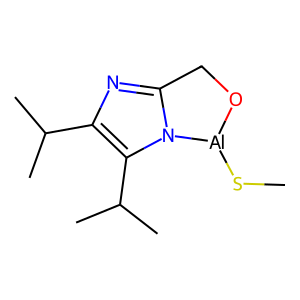

Substructure SMILES mol:


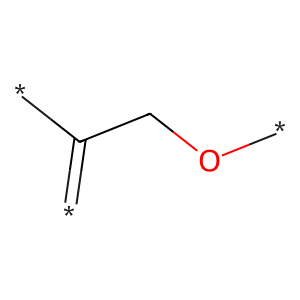

SMILES: [H]C([H])([H])S[Al]1OC([H])([H])c2nc(C([H])(C([H])([H])[H])C([H])([H])[H])c(C([H])(C([H])([H])[H])C([H])([H])[H])n21
Substructure SMILES: *C(=*)C[O]
------------------------------------------------------------------------------------------------
No match!
Main mol:


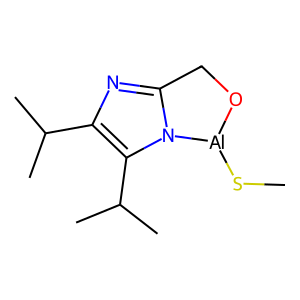

Substructure SMILES mol:


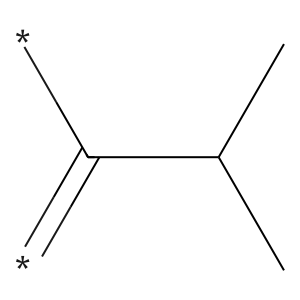

SMILES: [H]C([H])([H])S[Al]1OC([H])([H])c2nc(C([H])(C([H])([H])[H])C([H])([H])[H])c(C([H])(C([H])([H])[H])C([H])([H])[H])n21
Substructure SMILES: *C(=*)C(C)C
------------------------------------------------------------------------------------------------
No match!
Main mol:


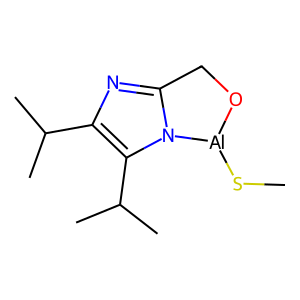

Substructure SMILES mol:


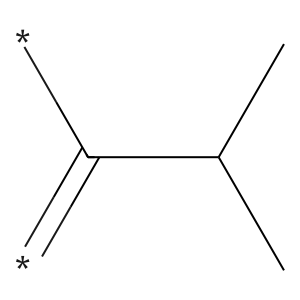

  0%|                                                                                                                                      | 3/44877 [00:00<27:09, 27.55it/s]

SMILES: [H]C([H])([H])S[Al]1OC([H])([H])c2nc(C([H])(C([H])([H])[H])C([H])([H])[H])c(C([H])(C([H])([H])[H])C([H])([H])[H])n21
Substructure SMILES: *C(=*)C(C)C
------------------------------------------------------------------------------------------------
No match!
Main mol:


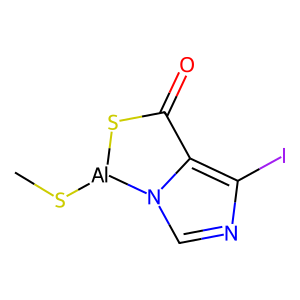

Substructure SMILES mol:


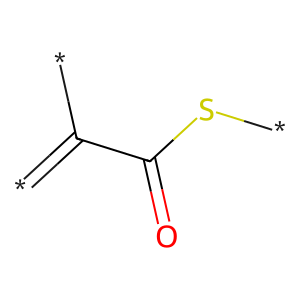

SMILES: [H]c1nc(I)c2n1[Al](SC([H])([H])[H])SC2=O
Substructure SMILES: *C(=*)C(=O)[S]
------------------------------------------------------------------------------------------------
No match!
Main mol:


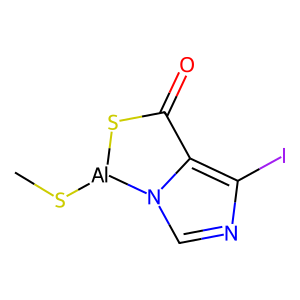

Substructure SMILES mol:


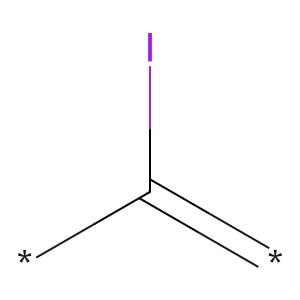

SMILES: [H]c1nc(I)c2n1[Al](SC([H])([H])[H])SC2=O
Substructure SMILES: *C(=*)I
------------------------------------------------------------------------------------------------
No match!
Main mol:


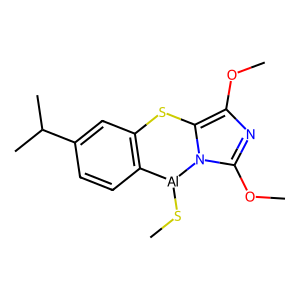

Substructure SMILES mol:


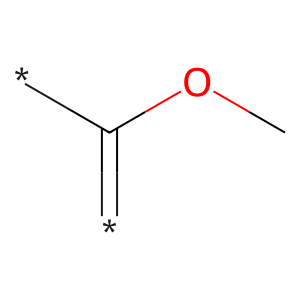

SMILES: [H]c1c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c2c1[Al](SC([H])([H])[H])n1c(OC([H])([H])[H])nc(OC([H])([H])[H])c1S2
Substructure SMILES: *C(=*)OC
------------------------------------------------------------------------------------------------
No match!
Main mol:


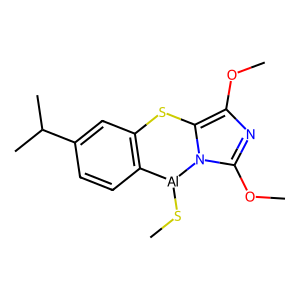

Substructure SMILES mol:


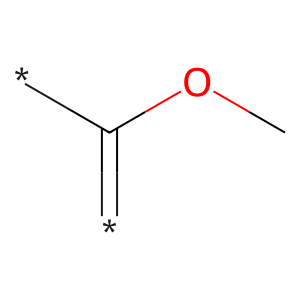

SMILES: [H]c1c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c2c1[Al](SC([H])([H])[H])n1c(OC([H])([H])[H])nc(OC([H])([H])[H])c1S2
Substructure SMILES: *C(=*)OC
------------------------------------------------------------------------------------------------
No match!
Main mol:


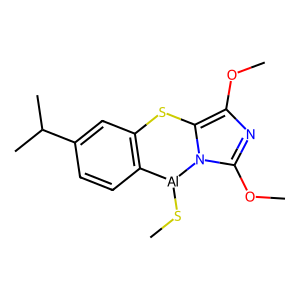

Substructure SMILES mol:


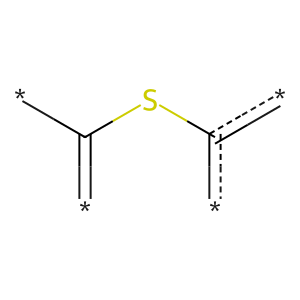

SMILES: [H]c1c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c([H])c2c1[Al](SC([H])([H])[H])n1c(OC([H])([H])[H])nc(OC([H])([H])[H])c1S2
Substructure SMILES: *C(=*)SC(:*):*
------------------------------------------------------------------------------------------------
No match!
Main mol:


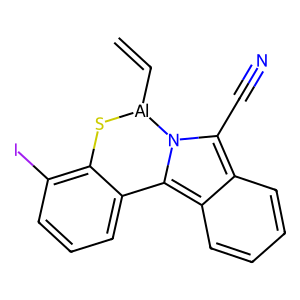

Substructure SMILES mol:


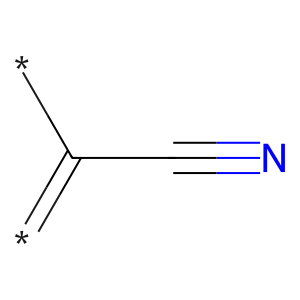

  0%|                                                                                                                                     | 12/44877 [00:00<11:53, 62.85it/s]

SMILES: [H]C([H])=C([H])[Al]1Sc2c(I)c([H])c([H])c([H])c2-c2c3c([H])c([H])c([H])c([H])c3c(C#N)n21
Substructure SMILES: *C(=*)C#N
------------------------------------------------------------------------------------------------
No match!
Main mol:


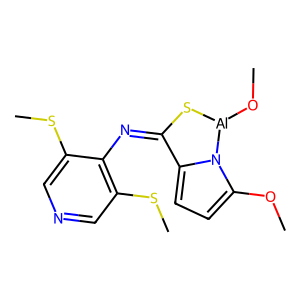

Substructure SMILES mol:


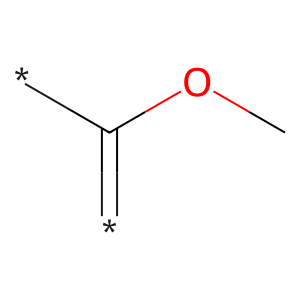

SMILES: [H]c1nc([H])c(SC([H])([H])[H])c(/N=C2/S[Al](OC([H])([H])[H])n3c(OC([H])([H])[H])c([H])c([H])c32)c1SC([H])([H])[H]
Substructure SMILES: *C(=*)OC
------------------------------------------------------------------------------------------------
No match!
Main mol:


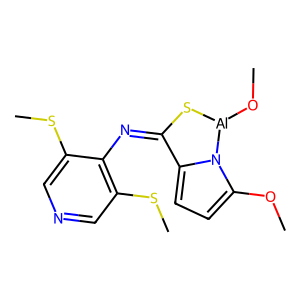

Substructure SMILES mol:


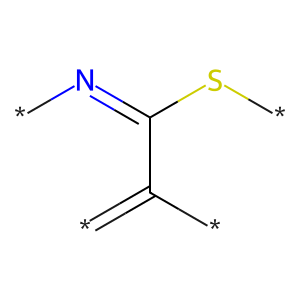

SMILES: [H]c1nc([H])c(SC([H])([H])[H])c(/N=C2/S[Al](OC([H])([H])[H])n3c(OC([H])([H])[H])c([H])c([H])c32)c1SC([H])([H])[H]
Substructure SMILES: */N=C(/[S])C(*)=*
------------------------------------------------------------------------------------------------
No match!
Main mol:


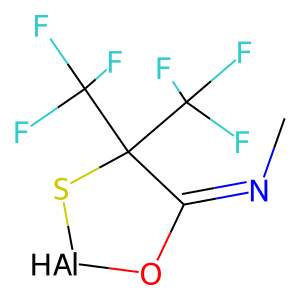

Substructure SMILES mol:


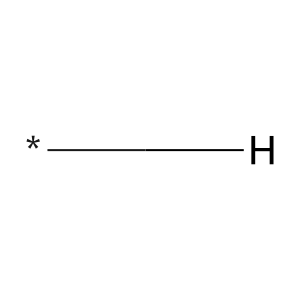

SMILES: [H][Al]1O/C(=N/C([H])([H])[H])C(C(F)(F)F)(C(F)(F)F)S1
Substructure SMILES: [H]
------------------------------------------------------------------------------------------------
No match!
Main mol:


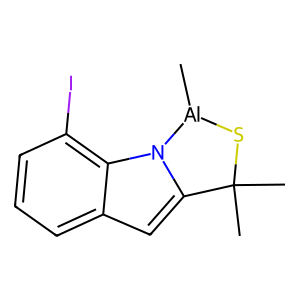

Substructure SMILES mol:


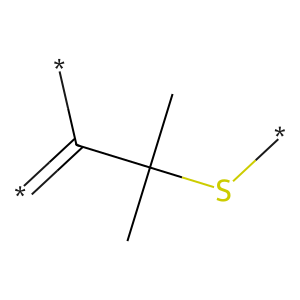

SMILES: [H]c1c([H])c(I)c2c(c1[H])c([H])c1n2[Al](C([H])([H])[H])SC1(C([H])([H])[H])C([H])([H])[H]
Substructure SMILES: *C(=*)C(C)(C)[S]
------------------------------------------------------------------------------------------------
No match!
Main mol:


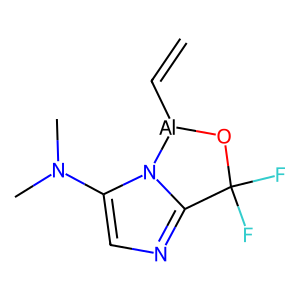

Substructure SMILES mol:


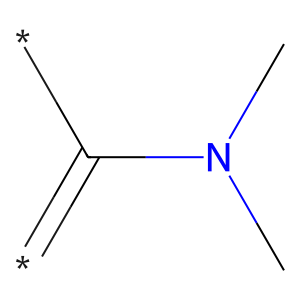

SMILES: [H]C([H])=C([H])[Al]1OC(F)(F)c2nc([H])c(N(C([H])([H])[H])C([H])([H])[H])n21
Substructure SMILES: *C(=*)N(C)C
------------------------------------------------------------------------------------------------
No match!
Main mol:


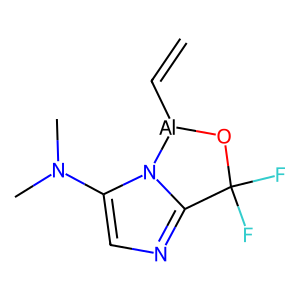

Substructure SMILES mol:


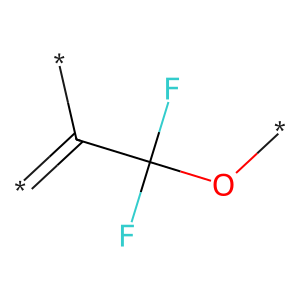

SMILES: [H]C([H])=C([H])[Al]1OC(F)(F)c2nc([H])c(N(C([H])([H])[H])C([H])([H])[H])n21
Substructure SMILES: *C(=*)C([O])(F)F
------------------------------------------------------------------------------------------------
No match!
Main mol:


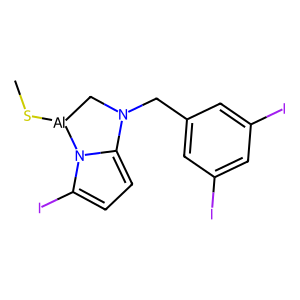

Substructure SMILES mol:


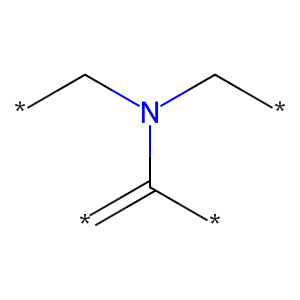

  0%|                                                                                                                                     | 22/44877 [00:00<10:01, 74.53it/s]

SMILES: [H]c1c(I)c([H])c(C([H])([H])N2c3c([H])c([H])c(I)n3[Al](SC([H])([H])[H])C2([H])[H])c([H])c1I
Substructure SMILES: *CN([CH2])C(*)=*
------------------------------------------------------------------------------------------------
No match!
Main mol:


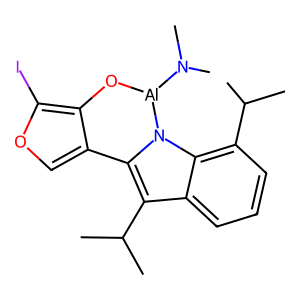

Substructure SMILES mol:


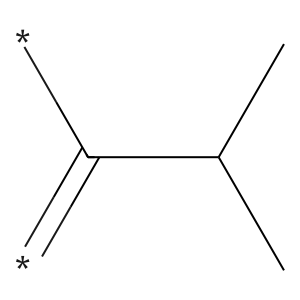

SMILES: [H]c1oc(I)c2c1-c1c(C([H])(C([H])([H])[H])C([H])([H])[H])c3c([H])c([H])c([H])c(C([H])(C([H])([H])[H])C([H])([H])[H])c3n1[Al](N(C([H])([H])[H])C([H])([H])[H])O2
Substructure SMILES: *C(=*)C(C)C
------------------------------------------------------------------------------------------------
No match!
Main mol:


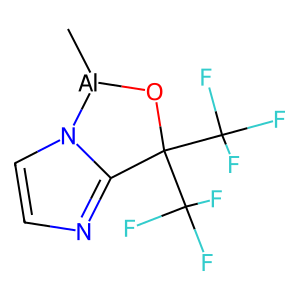

Substructure SMILES mol:


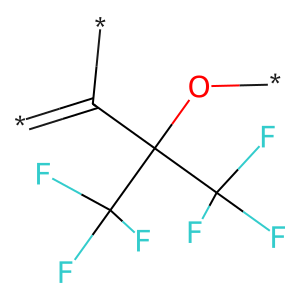

SMILES: [H]c1nc2n(c1[H])[Al](C([H])([H])[H])OC2(C(F)(F)F)C(F)(F)F
Substructure SMILES: *C(=*)C([O])(C(F)(F)F)C(F)(F)F
------------------------------------------------------------------------------------------------
No match!
Main mol:


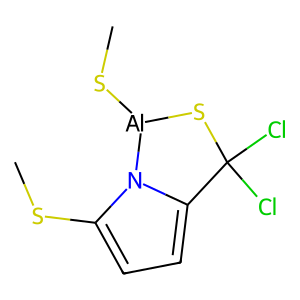

Substructure SMILES mol:


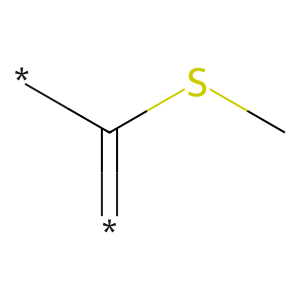

  0%|▏                                                                                                                                   | 46/44877 [00:00<06:38, 112.51it/s]


SMILES: [H]c1c([H])c2n(c1SC([H])([H])[H])[Al](SC([H])([H])[H])SC2(Cl)Cl
Substructure SMILES: *C(=*)SC
Counter({'found': 213, 'not_found': 20})


ValueError: Too many substructures not found. Aborting.

In [5]:
radius = 1

substructures = defaultdict(lambda: [[], [], 0.])

counter = Counter({"found": 0, "not_found": 0})
# write all substructures in list:
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = substructures[row["Compound"]]
    elem[2] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        sub_smiles = getSubSmilesRadN(Chem.MolFromSmiles(smi), radius)
        elem[0].extend((sub_smiles, radius))
        elem[1].extend(get_shortest_distance(sub_smiles, row["ca"], row["la_smiles"], counter))
    substructures[row["Compound"]] = elem
print(counter)

with open("substructures.json", "w") as f:
    #json.dump(substructure_list, f)
    json.dump(substructures, f)

### 1.2 Draw substructures

In [21]:
# load substructure_list:
with open("substructures.json", "r") as f:
    substructures_json = json.load(f)

# count substructures and append FIA values:
#substructure_counts = defaultdict(int)
#for i in substructure_list:
#    if i:
#        substructure_counts[i] += 1

# two-tuple of list of FIAs and substructure count
substructures = defaultdict(lambda: [[], 0])
for properties in substructures_json.values():
    # these are the substructures
    for substruct in properties[0]:
        substructures[substruct][0].append(properties[1])
        substructures[substruct][1] += 1

# sort substructure_counts by counts:
substructures = dict(sorted(substructures.items(), key=lambda item: item[1][1], reverse=True))
#substructure_counts = dict(sorted(substructure_counts.items(), key=lambda item: item[1], reverse=True))

# draw substructures:
smiles = list(substructures.keys())
counts = [str(x[1]) for x in substructures.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

substructures_highest_fia = dict(sorted(substructures.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 7

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(substructures_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}")
    legends.append(f"Substructure {i}: {k}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))

TypeError: unhashable type: 'list'

# 2. Analyze ring systems

### 2.1 Search for ring systems

In [9]:
ringsystems = defaultdict(lambda: [[], 0.])

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = ringsystems[row["Compound"]]
    elem[1] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        elem[0].extend(getRingSystemSmiles(Chem.MolFromSmiles(smi)))

with open("ringsystem.json", "w") as f:
    json.dump(ringsystems, f)

100%|████████████████████████████████████████| 44877/44877 [00:16<00:00, 2739.85it/s]


### 2.2 Draw ringsystems

/tmp/ipykernel_3186/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


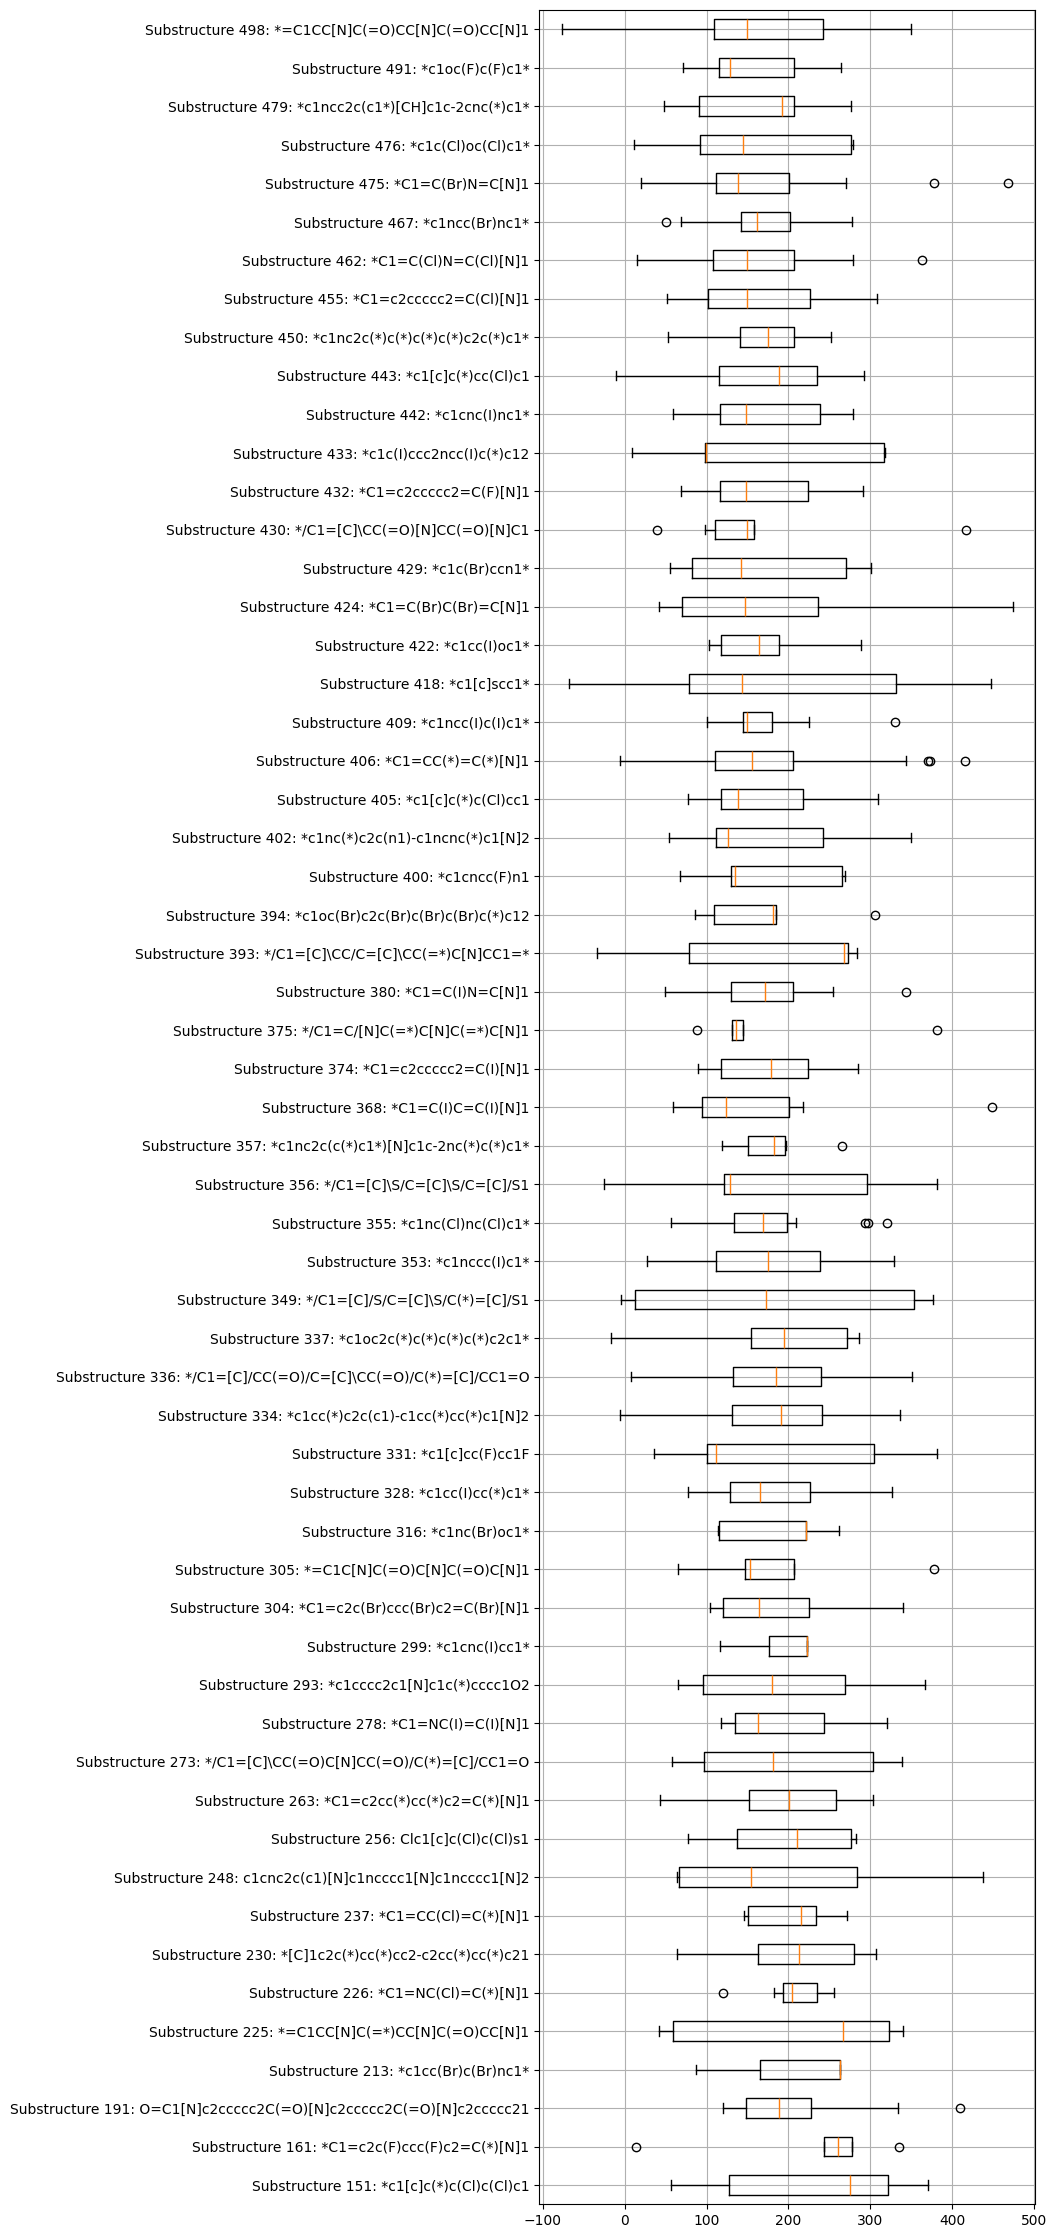

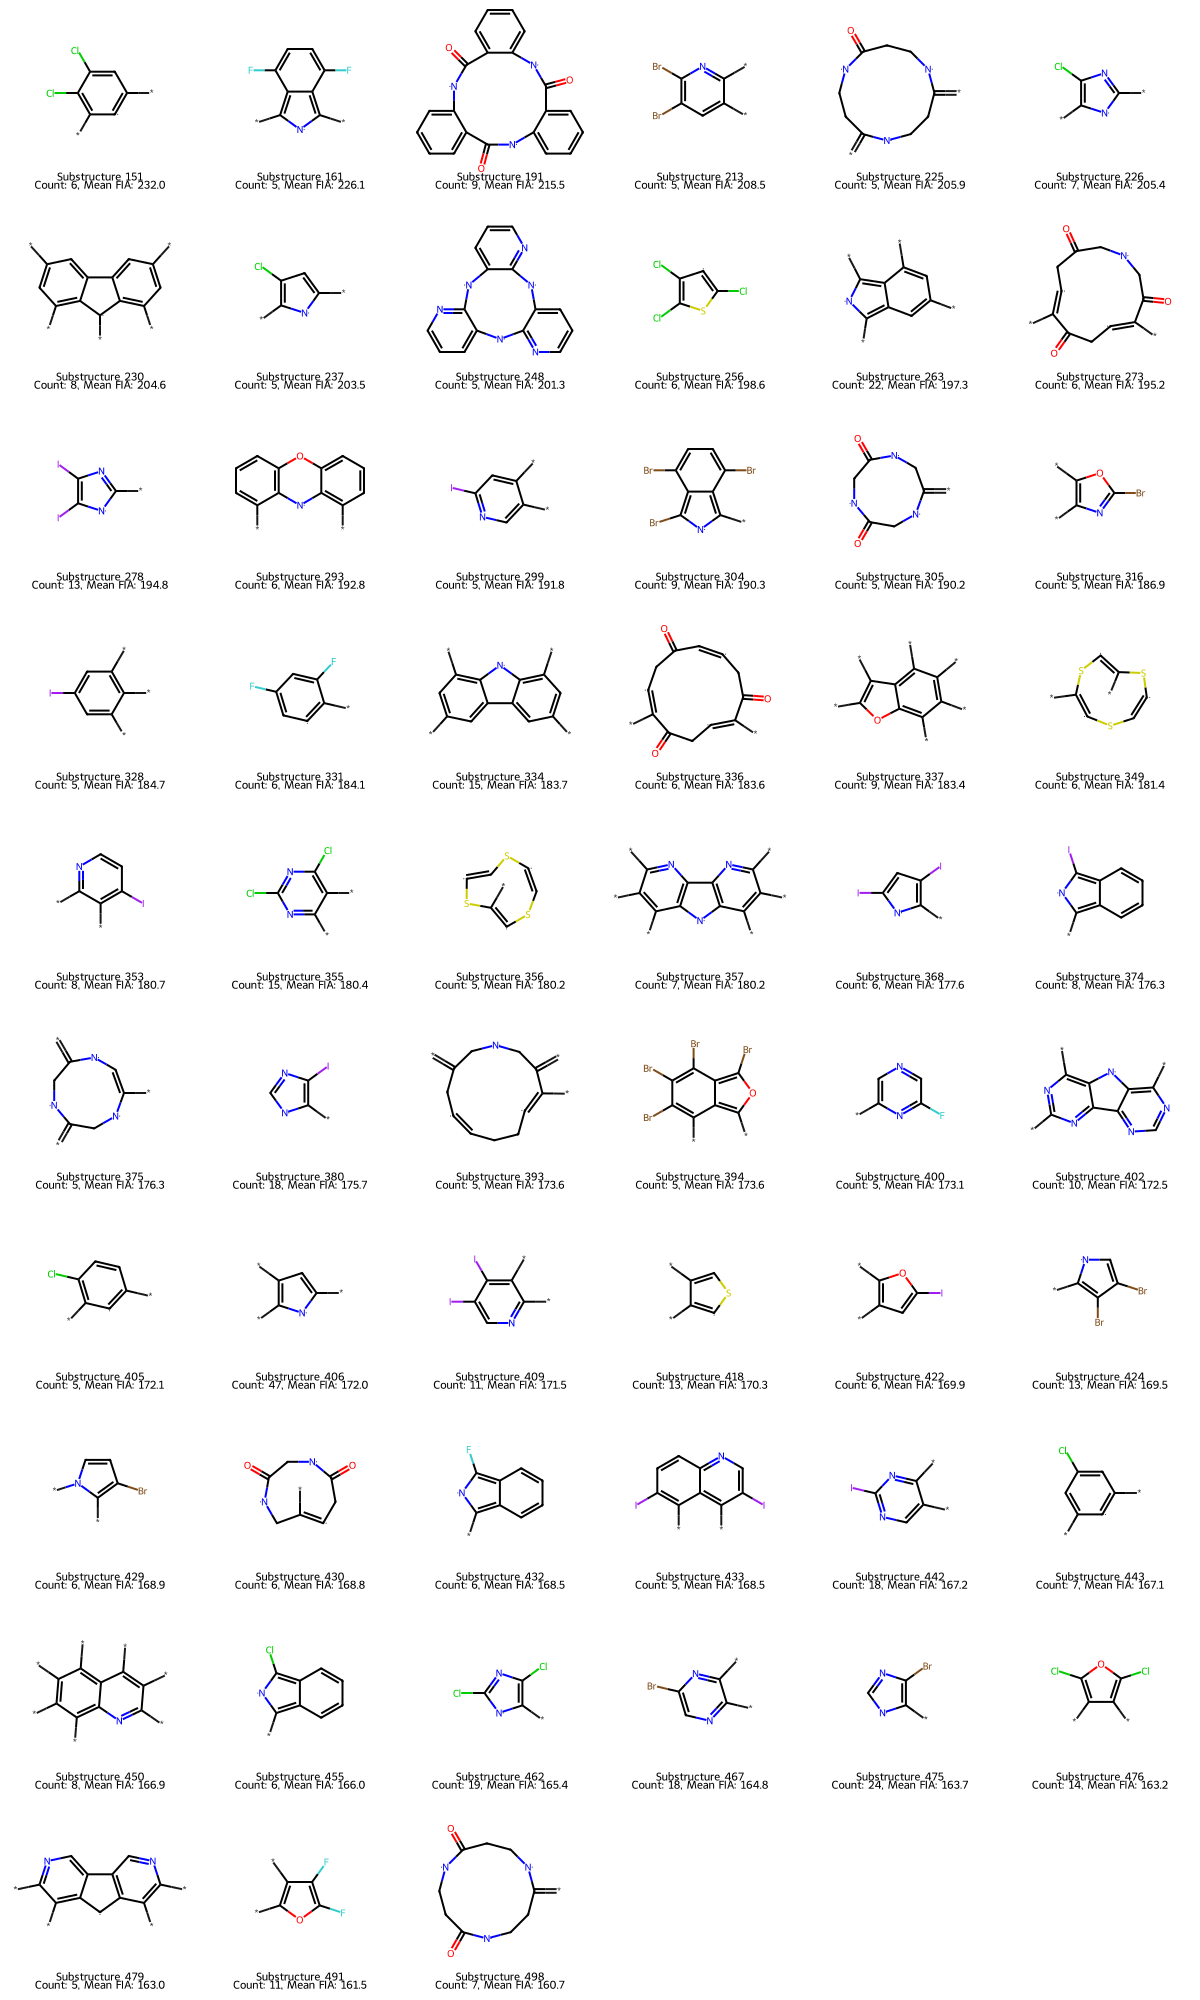

In [10]:
# load substructure_list:
with open("ringsystem.json", "r") as f:
    ringsystems_json = json.load(f)

# two-tuple of list of FIAs and ringsystem count
ringsystems = defaultdict(lambda: [[], 0])
for properties in ringsystems_json.values():
    # these are the substructures
    for substruct in properties[0]:
        ringsystems[substruct][0].append(properties[1])
        ringsystems[substruct][1] += 1

# sort substructure_counts by counts:
ringsystems = dict(sorted(ringsystems.items(), key=lambda item: item[1][1], reverse=True))

# draw substructures:
smiles = list(ringsystems.keys())
counts = [str(x[1]) for x in ringsystems.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

ringsystems_highest_fia = dict(sorted(ringsystems.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 5 

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(ringsystems_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}: {k}")
    legends.append(f"Substructure {i}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))